### Tools for taking seasonal means and averaging reanalysis temperature proiles

In [241]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from glob import glob
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage.filters import gaussian_filter1d
import pandas as pd
import calendar 
from matplotlib.font_manager import FontProperties
from scipy.interpolate import CubicSpline, BSpline

%run simulate_radiances_utils.py



In [242]:
save_final_figs_dir = '/home/cchristo/proj_christian/final_results/figs/'
save_data_dir_exper = '/net/fluo/data2/groupMembers/cchristo/profiles/experiment/change_tmean/'


In [243]:
path_to_reananlysis_profiles = '/net/fluo/data2/groupMembers/cchristo/profiles/summit_merra/summit_all.nc'
path_to_cloud_mask = '/net/fluo/data2/groupMembers/cchristo/misc_data/cloud_bool_rad_29.nc'


ds = xr.open_dataset(path_to_reananlysis_profiles)


cloud_mask_ds = xr.open_dataset(path_to_cloud_mask)
cloud_free_ds = cloud_mask_ds.where(cloud_mask_ds['cloud_free_bool'] == 1, drop = True)

ds = ds.sel(time = cloud_free_ds.time)

In [92]:
## get clear-sky only 
# ds.isel(time = 300)['T'].plot()

In [244]:
ds_seasonal = ds.groupby('time.season').mean(dim = 'time', skipna = True)
ds_annual = ds.mean(dim = 'time', skipna = True)

In [179]:
# ds_annual.to_netcdf(save_data_dir_exper + 'annual_mean.nc')

In [214]:
# p_diff = ds_seasonal.isel(season = 1)['PL'] - ds_seasonal.isel(season = 0)['PL']
# p_diff.plot()
p_prof, T_prof, dz_prof,  _,_,_,_ = compute_profile_properties_merra2(ds_annual,
                                                                      verbose = False)
z_prof = np.cumsum(dz_prof[::-1])
# ds_seasonal.isel(season = 0).where()
mean_below_press_pa = 30000
df_seas_i = ds_seasonal.isel(season = 0)
winter_mean_T = df_seas_i.where(df_seas_i['PL'] > mean_below_press_pa).mean()['T']

df_seas_i = ds_seasonal.isel(season = 1)
summer_mean_T = df_seas_i.where(df_seas_i['PL'] > mean_below_press_pa).mean()['T']

In [216]:
winter_prof = ds_seasonal.isel(season = 0)['T']
summer_prof = ds_seasonal.isel(season = 1)['T']
# seasonal_diff = summer_prof - winter_prof
seasonal_diff = (summer_mean_T - winter_mean_T).values
# winter_prof.plot()

summer_center = summer_prof - seasonal_diff/2
winter_center = winter_prof + seasonal_diff/2

In [122]:
# z_prof


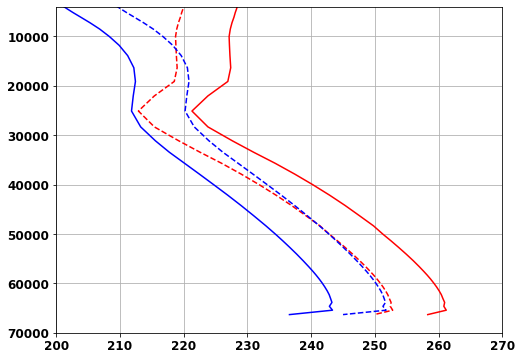

In [151]:
plt.figure(figsize = (8,6))
plt.plot(winter_prof.values, ds_annual['PL'].values, c = 'b')
plt.plot(summer_prof.values, ds_annual['PL'].values, c = 'r')
plt.plot(summer_center.values,ds_annual['PL'].values, linestyle = '--', c = 'r')
plt.plot(winter_center.values, ds_annual['PL'].values, linestyle = '--', c = 'b')

plt.gca().invert_yaxis()
plt.ylim([70000, 4000])
plt.xlim([200, 270])
plt.grid()

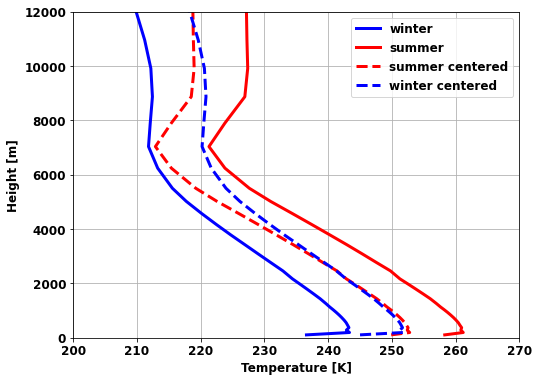

In [183]:
# seasonal_diff.plot()
plt.figure(figsize = (8,6))
linewidth = 3
plt.plot(winter_prof.values[::-1], z_prof, c = 'b', linewidth = linewidth, label = 'winter')
plt.plot(summer_prof.values[::-1], z_prof, c = 'r', linewidth = linewidth, label = 'summer')
plt.plot(summer_center.values[::-1], z_prof, linestyle = '--', c = 'r', linewidth = linewidth, label = 'summer centered')
plt.plot(winter_center.values[::-1], z_prof, linestyle = '--', c = 'b', linewidth = linewidth, label = 'winter centered')
plt.legend()
# plt.gca().invert_yaxis()
# plt.ylim([70000, 4000])
plt.xlabel('Temperature [K]', weight = 'bold')
plt.ylabel('Height [m]', weight = 'bold')
plt.xlim([200, 270])
plt.ylim([0, 12000])
plt.grid()
plt.savefig(save_final_figs_dir + 'exper_vary_abs_temperature.png', dpi = 200)

In [173]:
ds_out = xr.Dataset()
ds_out['summer_center'] = summer_center
ds_out['winter_center'] = winter_center
ds_out['winter'] = winter_prof
ds_out['summer'] = summer_prof
ds_out['PL'] = ds_annual['PL']

ds_out = ds_out.drop('season')
# plt.plot(summer_center.values)
# ds_out.to_netcdf(save_data_dir_exper + 'all_profs.nc')

# Now vary absolute temperature

In [217]:
wint_sum_ave = (winter_prof + summer_prof)/2
# t_diff_2 = summer_prof - winter_prof
wint_pert = wint_sum_ave - (seasonal_diff/2)
summer_pert = wint_sum_ave + (seasonal_diff/2)

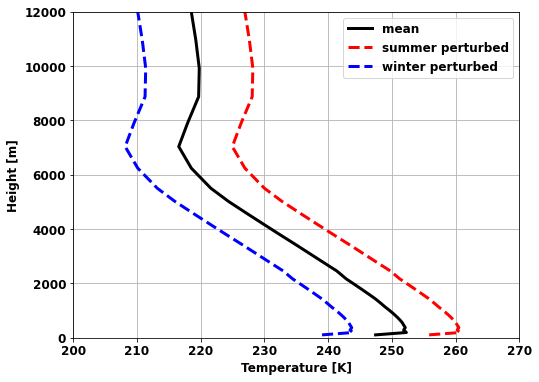

In [231]:
plt.figure(figsize = (8,6))
linewidth = 3
plt.plot(wint_sum_ave.values[::-1], z_prof, c = 'black', linewidth = linewidth, label = 'mean')
plt.plot(summer_pert.values[::-1], z_prof, linestyle = '--', c = 'r', linewidth = linewidth, label = 'summer perturbed')
plt.plot(wint_pert.values[::-1], z_prof, linestyle = '--', c = 'b', linewidth = linewidth, label = 'winter perturbed')
plt.legend()
# plt.gca().invert_yaxis()
# plt.ylim([70000, 4000])
plt.xlabel('Temperature [K]', weight = 'bold')
plt.ylabel('Height [m]', weight = 'bold')
plt.xlim([200, 270])
plt.ylim([0, 12000])
plt.grid()
# plt.savefig(save_final_figs_dir + 'exper_fixed_lapse_rate.png', dpi = 200)

In [233]:
ds_out = xr.Dataset()
ds_out['summer_pert'] = summer_pert
ds_out['winter_pert'] = wint_pert
ds_out['wint_sum_ave'] = wint_sum_ave
ds_out['PL'] = ds_annual['PL']

# ds_out = ds_out.drop('season')

In [236]:
# ds_out.to_netcdf('/net/fluo/data2/groupMembers/cchristo/profiles/experiment/fixed_lapse/' + 'exper_fixed_lapse.nc')

In [239]:
# ds_annual.to_netcdf('/net/fluo/data2/groupMembers/cchristo/profiles/experiment/fixed_lapse/' + 'annual_mean.nc')

# plot mean of each season and annual-mean

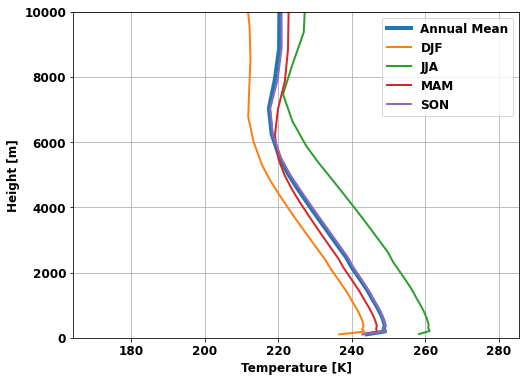

In [287]:

# p_prof = ds_annual['PL'].values
# T_prof = ds_annual['T'].values

p_prof, T_prof, dz_prof,  _,_,_,_ = compute_profile_properties_merra2(ds_annual,
                                                                      verbose = False)
z_prof = np.cumsum(dz_prof[::-1])
T_prof_incr = T_prof[::-1]
                                                                      
plot_profile(z_prof, T_prof_incr,    
             v_coord_type='height',
#              v_coord_type = 'pressure',
             newfig_bool = True, 
             min_pres = 3e2, 
             linewidth = 4,
             figsize = (8,6),
#              xlim = [1e-4, 1],
             xlabel = 'Temperature [K]',
             label = 'Annual Mean')

for seas_i in range(4):
    seas_ii = ds_seasonal.season.values[seas_i]
#     p_prof = ds_seasonal['PL'].sel(season = seas_ii).values
#     T_prof = ds_seasonal['T'].sel(season = seas_ii).values
    p_prof, T_prof, dz_prof,  _,_,_,_ = compute_profile_properties_merra2(ds_seasonal.sel(season = seas_ii), verbose = False)
    z_prof = np.cumsum(dz_prof[::-1])
    T_prof_incr = T_prof[::-1]
                                                                      
    plot_profile(z_prof, T_prof_incr, 
             v_coord_type='height',
             newfig_bool = False, 
              linewidth = 2,
#              xlim = [1e-4, 1],
             xlabel =  'Temperature [K]',
             label = seas_ii)
plt.ylim([0, 10000])
# plt.ylim([0, 300])
# plt.xlim([200, 270])
plt.legend()
# plt.gca().set_yscale('log')
# plt.savefig(save_final_figs_dir + 'mean_and_seasonal_temperature_profiles_merra.png', dpi = 300)

In [262]:
# ds.isel(time = 0)

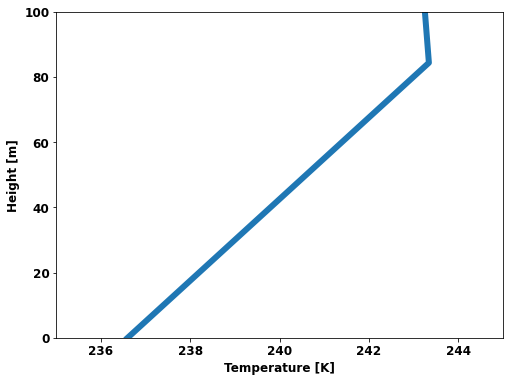

In [286]:
p_prof, T_prof, dz_prof,  _,_,_,_ = compute_profile_properties_merra2(ds_seasonal.isel(season = 0),
                                                                      verbose = False)
z_prof = np.cumsum(dz_prof[::-1])
T_prof_incr = T_prof[::-1]
                                                                      
plot_profile(z_prof - z_prof[0], T_prof_incr,    
             v_coord_type='height',
#              v_coord_type = 'pressure',
             newfig_bool = True, 
             min_pres = 3e2, 
             linewidth = 6,
             figsize = (8,6),
#              xlim = [1e-4, 1],
             xlabel = 'Temperature [K]',
             label = 'Annual Mean')
plt.ylim([0, 100])
plt.xlim([235, 245])
# plt.xlim()
plt.grid(False)
# plt.title('Inversion', weight = 'bold')
plt.savefig('/home/cchristo/proj_christian/final_results/figs/reanalysis_surface_zoom.png')

In [77]:
# ds_annual['T'][::-1].values
# T_diff = np.diff(ds_seasonal.isel(season = 1)['T'].values)

p_prof, T_prof, dz_prof,  _,_,_,_ = compute_profile_properties_merra2(ds_seasonal.isel(season = 0), verbose = False)
z_prof = np.cumsum(dz_prof[::-1])
T_prof_incr = T_prof[::-1]
T_prof_diff = np.diff(T_prof_incr, prepend = 0)/dz_prof

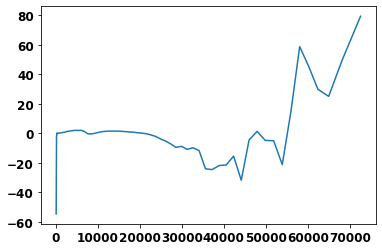

In [78]:
plt.plot(z_prof, T_prof_diff*(-1*1000))
# plt.ylim([0, 8])

In [73]:
p_prof, T_prof, dz_prof,  _,_,_,_ = compute_profile_properties_merra2(ds_seasonal.isel(season = 1), verbose = False)
z_prof = np.cumsum(dz_prof[::-1])
T_prof_incr = T_prof[::-1]
T_prof_diff = np.diff(T_prof_incr, prepend = 0)/dz_prof

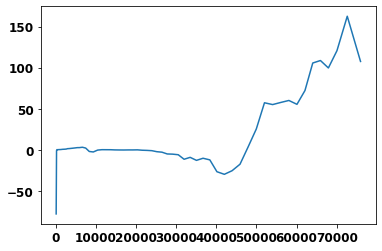

In [75]:
plt.plot(z_prof, T_prof_diff*(-1*1000))
# plt.ylim([0, 8])

In [28]:
save_final_data_dir = '/net/fluo/data2/groupMembers/cchristo/final_results/data/'



In [30]:
seasonal_fields = xr.open_dataset(save_final_data_dir + 'seasonal_co2_ds.nc')

In [32]:
seasonal_fields.isel(season = 0)['eh_CO2']

<xarray.DataArray 'eh_CO2' (nu: 130806)>
[130806 values with dtype=float64]
Coordinates:
  * nu       (nu) float64 491.8 491.8 491.8 491.8 ... 1.8e+03 1.8e+03 1.8e+03
    season   <U3 'DJF'

In [33]:
plot_emission_height(seasonal_fields.nu.values, 
                     seasonal_fields.isel(season = 0)['eh_CO2'].values, 
                     T_prof_0, 
                     z_prof_0,
                     label = 'Emission Height (CO2) [400 ppm]',
                     xlim = [650,700], ylim = [0, 200])

NameError: name 'T_prof_0' is not defined

# Stephan-Bolzman Law

In [29]:
os.listdir(save_final_data_dir)

['CH4_rf_timeseries.nc',
 'CO2_rf_timeseries.nc',
 'CH4_eh_radiance_weighted_timeseries.nc',
 'forcing_spectral_residual_CO2_summer_mean.nc',
 'forcing_spectral_residual_CO2_winter_mean.nc',
 'forcing_spectral_residual_CH4_summer_mean.nc',
 'forcing_spectral_residual_CH4_winter_mean.nc',
 'mean_surface_spectrum_components.nc',
 'mean_preindust_surface_spectrum_components.nc',
 'CO2_preindus_eh_radiance_weighted_timeseries.nc',
 'CH4_preindus_eh_radiance_weighted_timeseries.nc',
 'CO2_eh_radiance_weighted_timeseries.nc',
 'CO2_eh_rf_weighted_timeseries.nc',
 'CH4_eh_rf_weighted_timeseries.nc',
 'seasonal_co2_ds.nc',
 'seasonal_co2_preindust_ds.nc']